In [1]:
import re
import env
import pandas as pd
from env import PERSIST_DIRECTORY
import matplotlib.pyplot as plt


In [2]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings()
smalldb = Chroma(persist_directory=PERSIST_DIRECTORY, embedding_function=embedding)


In [3]:
with open('WhatsApp Chat with Gastos.txt', 'r') as file:
    data = file.read()
messages = data.split('\n')

In [4]:
def get_amount(text):
    pattern_k = r"(\d+\.?\d*)\s*k"
    pattern_pesos = r"(\d+\.?\d*)"
    pattern_usd = r"(\d+\.?\d*)\s*usd"

    match_k = re.search(pattern_k, text, re.IGNORECASE)
    match_usd = re.search(pattern_usd, text, re.IGNORECASE)
    match_pesos = re.search(pattern_pesos, text, re.IGNORECASE)

    if match_k:
        amount = float(match_k.group(1)) * 1000 if match_k.group(1) else 0.0
        currency = "pesos"
        description = re.sub(pattern_k, "", text, re.IGNORECASE).strip()
    elif match_usd:
        amount = float(match_usd.group(1)) if match_usd.group(1) else 0.0
        currency = "usd"
        description = re.sub(pattern_usd, "", text, re.IGNORECASE).strip()
    elif match_pesos:        
        amount = float(match_pesos.group(1)) if match_pesos else 0.0
        currency = "pesos"
        description = re.sub(pattern_pesos, "", text, re.IGNORECASE).strip()

    return (description, amount, currency)

In [5]:
df = pd.DataFrame(columns = ["row"], data=messages)
df = df[df["row"].str.contains(": ", na=False)]

df["date"] = df["row"].str.extract(r'(\d+/\d+/\d+)')
df["date"] = pd.to_datetime(df["date"], format='%m/%d/%y')

df["message"] = df["row"].str.split(": ").str[1]
df[["description", "amount", "currency"]] = df.apply(lambda row: get_amount(row["message"]), axis=1, result_type="expand")

df["category"] = df["message"].apply(lambda message: smalldb.similarity_search(message, k=1)[0].metadata["category"])

df.drop(columns=["row", "message"], inplace=True)

In [16]:
este_mes = df[df["date"].dt.month == 2]

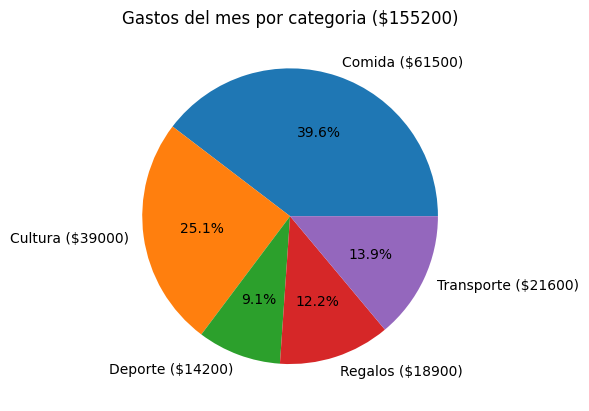

In [17]:
este_mes = este_mes.sort_values("category")

total_mes = este_mes["amount"].sum()
amount_by_category = este_mes[["category", "amount"]].groupby("category").sum().reset_index()
amount_by_category["category"] = amount_by_category["category"] + " ($" + amount_by_category["amount"].astype(int).astype(str) + ")"
plt.pie(amount_by_category["amount"], labels=amount_by_category["category"], autopct='%1.1f%%')
plt.title(f"Gastos del mes por categoria (${int(total_mes)})")
plt.show()

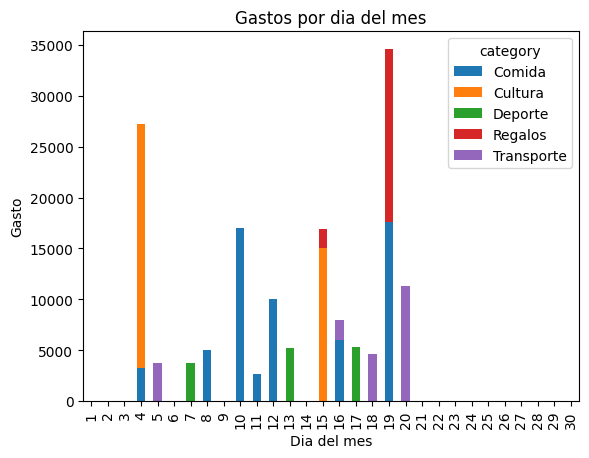

In [18]:
from itertools import product

este_mes.loc[:, "day_of_month"] = este_mes["date"].dt.day
all_days = pd.DataFrame(
    list(product(range(1, 31), este_mes.category.unique())),
    columns=["day_of_month", "category"],
)

amount_by_day = (
    este_mes[["day_of_month", "category", "amount"]]
    .groupby(["day_of_month", "category"])
    .sum()
    .reset_index()
)

amount_by_day = all_days.merge(
    amount_by_day, on=["day_of_month", "category"], how="left"
).fillna(0)

amount_by_day = amount_by_day.pivot(
    index="day_of_month", columns="category", values="amount"
).fillna(0)

amount_by_day.plot(kind="bar", stacked=True)

plt.xlabel("Dia del mes")
plt.ylabel("Gasto")
plt.title("Gastos por dia del mes")
plt.show()

In [63]:
este_mes

,date,message,amount,currency,category,day_of_month
4,2024-01-16,12k gorrión café juli,12000.0,pesos,Comida,16
21,2024-01-29,3000 tacos roni,3000.0,pesos,Comida,29
18,2024-01-27,10k hamburguesas veganas,10000.0,pesos,Comida,27
17,2024-01-27,3.2k tes vainilla supermercado,3200.0,pesos,Comida,27
16,2024-01-27,3.8k tequeños restaurantes t bares,3800.0,pesos,Comida,27
13,2024-01-23,4.2k empanadas vittor cena,4200.0,pesos,Comida,23
15,2024-01-25,3.4k comida facultad,3400.0,pesos,Comida,25
11,2024-01-20,10k cosas para key lime pie supermercado,10000.0,pesos,Comida,20
10,2024-01-20,400 restaurant lo de ale,400.0,pesos,Comida,20
9,2024-01-19,4.5k cine juli,4500.0,pesos,Comida,19
